<a href="https://colab.research.google.com/github/hesther/teaching/blob/main/demos/short_demo_goflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

sample_data


In [2]:
!git clone https://github.com/heid-lab/goflow.git
%cd goflow
!pip install uv
!uv python pin 3.12.6
!uv sync -n
!uv pip install ase torch rdkit hydra-core lightning torchdiffeq
!uv pip install torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-2.6.0+cu124.html --no-build-isolation -n

Streaming output truncated to the last 5000 lines.
nvidia-cufft-cu12        ------------------------------ 178.79 MiB/201.66 MiB
triton                   ------------------------------ 173.14 MiB/241.43 MiB
nvidia-cublas-cu12       ------------------------------ 179.16 MiB/346.60 MiB
nvidia-cudnn-cu12        ------------------------------ 179.72 MiB/633.96 MiB
⠧ Preparing packages... (103/110)
nvidia-cusparse-cu12     ------------------------------ 179.18 MiB/197.84 MiB
nvidia-cufft-cu12        ------------------------------ 178.81 MiB/201.66 MiB
triton                   ------------------------------ 173.47 MiB/241.43 MiB
nvidia-cublas-cu12       ------------------------------ 179.16 MiB/346.60 MiB
nvidia-cudnn-cu12        ------------------------------ 179.72 MiB/633.96 MiB
⠧ Preparing packages... (103/110)
nvidia-cusparse-cu12     ------------------------------ 179.43 MiB/197.84 MiB
nvidia-cufft-cu12        ------------------------------ 179.10 MiB/201.66 MiB
triton                 

## 1. Load reaction data
Essential functions to load and store reactions from smiles strings.

### Practical Notes
1) In practice we first run the `preprocessing.py` script to generate the processed `Data` objects for all reactions, given the raw data (.csv and .xyz files).
2) We store those `Data` objects into their respective pickle file (`data.pkl`).

#### Example command for preprocessing:
```
DATA_PATH="data/RDB7"
FULL_CSV="$DATA_PATH/raw_data/rdb7_full.csv"
FULL_XYZ="$DATA_PATH/raw_data/rdb7_full.xyz"
SAVE_DIR="$DATA_PATH/processed_data"

python preprocessing_lite.py \
    --csv_file "$FULL_CSV" \
    --xyz_file "$FULL_XYZ" \
    --save_dir "$SAVE_DIR"

```

In [3]:
!python preprocessing.py \
    --csv_file "data/RDB7/raw_data/rdb7_full.csv" \
    --xyz_file "data/RDB7/raw_data/rdb7_full.xyz" \
    --save_dir "data/RDB7/processed_data"

xxx.pkl is not exist. Use default feat_dict.
11926it [00:22, 532.32it/s]


If you want to use your own data, you will need a csv file. The "rxn" (index) and "smiles" columns are mandatory.

In [4]:
import pandas as pd
pd.read_csv("data/RDB7/raw_data/rdb7_full.csv")

,rxn,smiles,dE0
0,0,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,48.61085
1,1,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,74.02980
2,2,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,97.42200
3,3,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,75.25375
4,4,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,72.16356
...,...,...,...
11921,11956,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,75.56813
11922,11957,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,42.41621
11923,11958,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,72.75039
11924,11959,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,65.83112


Then, you need an xyz file with reactant, transition state and product conformations, in exactly the same order as the csv file, i.e.

```
rxn 0, reactants
rxn 0, transition state
rxn 0, products
rxn 1, reactants
rxn 1, transition state
rxn 1, products
...
```

In [5]:
!head data/RDB7/raw_data/rdb7_full.xyz

9

C      -1.308713000000000      0.006799000000000      0.031843000000000
C       0.171548000000000     -0.034422000000000      0.020955000000000
N       0.905448000000000     -0.900088000000000      0.639517000000000
O       2.168252000000000     -0.548326000000000      0.343667000000000
N       2.149930000000000      0.544935000000000     -0.463100000000000
N       0.961326000000000      0.865486000000000     -0.665988000000000
H      -1.655844000000000      0.950464000000000      0.453037000000000
H      -1.693359000000000     -0.067998000000000     -0.985392000000000


If you use your own data, you will also have to make pickle file with the rxn indices for the train/val/test splits. Please refer to the repo to make them. Here, we will use predefined splits shipped with the repo.

For this demo, we will only use a single reaction type, thus reopen data.pkl and only select certain reactions. This is only to improve runtime for the demo:

In [9]:
import ast
import pickle

d = pd.read_csv("data/RDB7/raw_data/reaction_types.csv")
all_indices = ast.literal_eval(d['reaction_indices'][10])

with open('data/RDB7/processed_data/data.pkl', 'rb') as f:
    test_data_processed_R = pickle.load(f)

test_data_processed_R = [x for x in test_data_processed_R if x['rxn_index'] in all_indices]
print(len(test_data_processed_R))
with open('data/RDB7/processed_data/data.pkl', 'wb') as f:
    pickle.dump(test_data_processed_R, f)

101


Since we now have subselected the dataset, we also have to make a new split file:

In [12]:
import numpy as np

np.random.shuffle(all_indices)
total_size = len(all_indices)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
train_indices = all_indices[:train_size]
val_indices = all_indices[train_size:train_size + val_size]
test_indices = all_indices[train_size + val_size:]
split_dict = {
      'train': train_indices,
      'val': val_indices,
      'test': test_indices
  }

with open('data/RDB7/splits/random_split.pkl', 'wb') as f:
    pickle.dump(split_dict, f)


### Plot Graph of Sample Reaction

Let's inspect a data point:

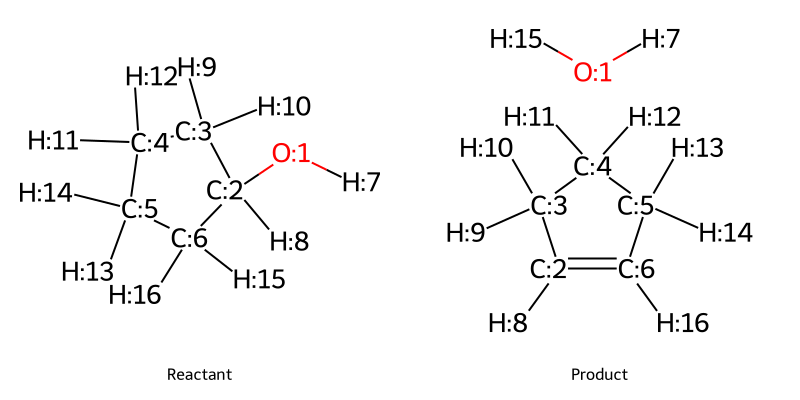

In [10]:
from rdkit import Chem

EXAMPLE_RXN_IDX = 0

# Get the example rxn smiles string from the processed data.
r_smiles, p_smiles = test_data_processed_R[EXAMPLE_RXN_IDX].smiles.split('>>')

# RdKit functions to convert the two reactand and product strings to RdKit Mol objects (r_mol, p_mol)
params = Chem.SmilesParserParams()
params.removeHs = False
r_mol, p_mol = Chem.MolFromSmiles(r_smiles, params), Chem.MolFromSmiles(p_smiles, params)
Chem.SanitizeMol(r_mol)
Chem.SanitizeMol(p_mol)
Chem.Draw.MolsToGridImage(
    [r_mol, p_mol],
    legends=["Reactant", "Product"],
    molsPerRow=2,
    subImgSize=(400, 400)
)

# 2. Train and Test GoFlow in the Terminal
GoFlow uses Hydra, which makes it easy to specify experimental setups right from the command line.

Fpr example, to train GoFlow three times, once with the reaction core split, the barrier height split, and the random split, we can simply run

```
python flow_train.py -m \
    data.split_file="rxn_core_split.pkl","barrier_split.pkl","random_split.pkl" \
    model.num_steps=25 \
    model.num_samples=25 \
    task_name=train_test_all_splits
```

`data.split_file` specifies which split to use. To only train on e.g. random_split, just remove the others.

`model.num_steps` specifies the number of ODE steps to take from t=0 to t=1.

`model.num_samples` specifies the number of samples to take for each reaction, to then take the 'median reaction' ouf of those.

`task_name` specifies the experiment name locally and on w&b.

The script also automatically evaluates the final trained model on the test-set.

In [15]:
!python flow_train.py -m \
    data.split_file="random_split.pkl" \
    model.num_steps=25 \
    model.num_samples=25 \
    trainer.max_epochs=20 \
    task_name=train_test_single_type

[2025-06-24 09:28:48,716][HYDRA] Launching 1 jobs locally
[2025-06-24 09:28:48,716][HYDRA] 	#0 : data.split_file=random_split.pkl model.num_steps=25 model.num_samples=25 trainer.max_epochs=20 task_name=train_test_single_type
Seed set to 1
[2025-06-24 09:28:48,876][__main__][INFO] - [rank: 0] Instantiating datamodule <gotennet.data.components.rdb7.RDB7DataModule>
[2025-06-24 09:28:48,978][__main__][INFO] - [rank: 0] Instantiating model <flow_matching.flow_module.FlowModule>
[2025-06-24 09:28:48,981][gotennet.models.representation.gotennet][INFO] - [rank: 0] Using xavier_uniform weight initialization
/usr/local/lib/python3.11/dist-packages/torch_geometric/nn/conv/message_passing.py:1032: UserWarning: 'NodeInit.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "
/usr/local/lib/python3.11/dist-packages/torch_geometric/nn/conv/message_passing.py:1032: UserWarning: 'EdgeInit.jittable' is deprecated and a no-op. 

You should now see the finished job in the logs:

In [28]:
!ls -lrt logs/train_test_single_type/multiruns/

total 12
drwxr-xr-x 3 root root 4096 Jun 24 09:19 2025-06-24_09-19-15
drwxr-xr-x 3 root root 4096 Jun 24 09:22 2025-06-24_09-22-56
drwxr-xr-x 3 root root 4096 Jun 24 09:28 2025-06-24_09-28-48


In [47]:
with open('logs/train_test_single_type/multiruns/2025-06-24_09-28-48/0/test_samples/samples_all.pkl', 'rb') as f:
    test_samples = pickle.load(f)
print(len(test_samples))
test_samples[0]

11


Data(edge_index=[2, 22], pos=[10, 3, 3], atom_type=[10], r_feat=[10, 27], p_feat=[10, 27], r_chiraltype=[10], p_chiraltype=[10], r_edge_index=[2, 20], p_edge_index=[2, 18], edge_type=[22], rdmol=[2], smiles='[O:1]([C:2]1([H:6])[C:3]([H:7])([H:8])[C:4]1([H:9])[H:10])[H:5]>>[C:2]1([H:6])=[C:3]([H:7])[C:4]1([H:9])[H:10].[O:1]([H:5])[H:8]', r_index_to_mapnum=[10], p_index_to_mapnum=[10], mapnum_to_r_index=[10], mapnum_to_p_index=[10], augmented=[1], rxn_index=[1], num_nodes_per_graph=[1], num_nodes=10, batch=[250], pos_gen=[25, 10, 3])

We can visualize for example the first of 25 generated conformers for the first reaction of the test set. Of course, this looks terrible because we trained on a tiny dataset for only 10 epochs:

In [52]:
from ase import Atoms
from ase.visualize import view

test_idx = 0
sample_idx = 0
m = Atoms(numbers=test_samples[test_idx].atom_type, positions=test_samples[test_idx].pos_gen[sample_idx])
view(m, viewer='x3d')

## 3. Train GoFlow with Code
Here we briefly show how to instantiate GoFlow, set parameters and train it. The goal is to get familiar with the basics of the internals.

#### Load Data

In [32]:
from torch.utils.data import Subset
from utils.datasets import ConformationDataset
from hydra import compose, initialize

# Custom torch_geometric dataset class that loads the reaction data from the pickle file.
full_ds = ConformationDataset(path='data/RDB7/processed_data/data.pkl')

# Split the dataset into training and test sets.
n = len(full_ds)
n_test = int(0.2 * n)
train_ds = Subset(full_ds, list(range(0, n - n_test)))
test_ds  = Subset(full_ds, list(range(n - n_test, n)))
print(f"Train/test sizes: {len(train_ds)}/{len(test_ds)}")

Train/test sizes: 81/20


#### Training Utilities

In [34]:
import hydra
import torch
from flow_matching.flow_module import FlowModule
from torch_geometric.loader import DataLoader
from torch.optim import AdamW
from flow_matching.utils import (
    rmsd_loss,
    get_shortest_path_fast_batched_x_1,
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

def get_model(cfg):
    model: FlowModule = hydra.utils.instantiate(cfg.model)
    model.to(DEVICE)
    return model

def get_perturbed_point(batch):
    """
    Generate a random atomic positions x_0_N_3 and interpolate with the reference positions x_1_N_3 to get x_t_N_3.
    """
    x_1_N_3 = batch.pos[:, 1, :]

    # Generate random initial positions x_0_N_3
    x_0_N_3 = torch.randn_like(x_1_N_3, device=DEVICE)
    # Sample a random time t_G for each graph in the batch
    t_G = torch.rand(batch.num_graphs, 1, device=DEVICE)
    # Repeat t_G for each atom in the graph
    t_N = t_G[batch.batch]

    # Align x_0_N_3 to x_1_N_3 using the Kabsch algorithm
    x_1_aligned_N_3 = get_shortest_path_fast_batched_x_1(x_0_N_3, x_1_N_3, batch)
    # Interpolate between x_0_N_3 and x_1_aligned_N_3
    x_t_N_3 = (1 - t_N) * x_0_N_3 + t_N * x_1_aligned_N_3
    # Calculate the velocity dx_dt_N_3
    dx_dt_N_3 = x_1_aligned_N_3 - x_0_N_3

    return x_t_N_3, dx_dt_N_3, t_G

def rsd_loss(pred_N_3, gt_N_3):
    return torch.linalg.vector_norm(pred_N_3 - gt_N_3, dim=1).sum()

def train_and_save(cfg, dataset, save_path, epochs=200, batch_size=32):
    """
    Train the model and save the checkpoints.
    """
    cfg = cfg.copy()
    model = get_model(cfg)
    model.train()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=cfg.model.lr, weight_decay=model.weight_decay, eps=1e-7)

    for epoch in range(epochs):
        total_loss = 0.0
        total_N = 0
        for batch in loader:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()

            x_t_N_3, dx_dt_N_3, t_G = get_perturbed_point(batch)
            atom_N_3 = model.model_output(x_t_N_3, batch, t_G)
            loss = rmsd_loss(atom_N_3, dx_dt_N_3)
            loss.backward()
            optimizer.step()

            total_loss += rsd_loss(atom_N_3, dx_dt_N_3).item()
            if loss.item() > 100:
                print(f'Large loss detected: {loss.item()} at epoch {epoch}')
            total_N += atom_N_3.shape[0]

        avg_loss = total_loss / total_N
        print(f'Epoch {epoch:4d}  Avg Loss: {avg_loss:.5f}')

    torch.save(model.state_dict(), save_path)
    return model

#### Load Model Configuration
We use Hydra for configuring our model.

In [35]:
from hydra import initialize_config_module

# set some parameters for training
batch_size = 32
epochs = 10
dropout = 0.1
n_atom_basis = 256

# Load Hydra config manually for Jupyter Notebook
with initialize_config_module("configs", version_base="1.3"):
    cfg = compose(config_name="train.yaml")

# Optional: change the default parameters of the loaded config
cfg.model.representation.attn_dropout = dropout
cfg.model.representation.n_atom_rdkit_feats = 27
cfg.model.representation.n_atom_basis = n_atom_basis


#### Train

In [36]:
model_name = "goflow_model.pt"
goflow = train_and_save(
    cfg,
    train_ds,
    model_name,
    epochs,
    batch_size
)

/usr/local/lib/python3.11/dist-packages/torch_geometric/nn/conv/message_passing.py:1032: UserWarning: 'NodeInit.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "
/usr/local/lib/python3.11/dist-packages/torch_geometric/nn/conv/message_passing.py:1032: UserWarning: 'EdgeInit.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "
/usr/local/lib/python3.11/dist-packages/torch_geometric/nn/conv/message_passing.py:1032: UserWarning: 'GATA.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'representation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['representa

FM has seed 1 -----------------------------
Epoch    0  Avg Loss: 5.66337
Epoch    1  Avg Loss: 3.02331
Epoch    2  Avg Loss: 2.16035
Epoch    3  Avg Loss: 2.00816
Epoch    4  Avg Loss: 2.23127
Epoch    5  Avg Loss: 2.03511
Epoch    6  Avg Loss: 2.00969
Epoch    7  Avg Loss: 1.94239
Epoch    8  Avg Loss: 1.97889
Epoch    9  Avg Loss: 1.95321
